In [1]:
import numpy as np
import torch
from pprint import pprint

In [2]:
file = "./winequality-white.csv"
data = np.loadtxt(file, dtype=np.float32, delimiter=";", skiprows=1)

tmp = {'total' : 0}
for d in data:
    if d[-1] not in tmp:
        tmp[d[-1]] = 0
    tmp[d[-1]] += 1
    tmp['total'] += 1
print("데이터 편향성이....;;;;", tmp)

data_max = [0 for _ in range(len(data[0]))]
for d in data:
    for i, e in enumerate(d):
        data_max[i] = max(data_max[i], e)
for d in data:
    for i, _ in enumerate(d[:11]):
        d[i] /= data_max[i] # 정규화
print('data_max : ', data_max)

데이터 편향성이....;;;; {'total': 4898, 6.0: 2198, 5.0: 1457, 7.0: 880, 8.0: 175, 4.0: 163, 3.0: 20, 9.0: 5}
data_max :  [14.2, 1.1, 1.66, 65.8, 0.346, 289.0, 440.0, 1.03898, 3.82, 1.08, 14.2, 9.0]


# 문제점 1
6.0 퀄리티의 데이터가 너무 많다. 반면 그 이외의 데이터는 개수가 너무 적다. 이를 대응하기위한 몇가지 기법이 있으나, (주로 배치마다 종류별 데이터 개수를 동등하게 유지시켜주는) 먼저 데이터의 특성을 살펴보자

4


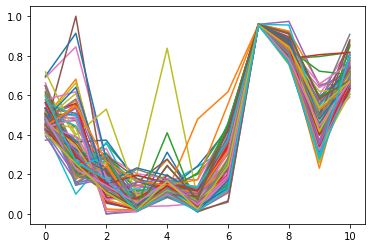

5


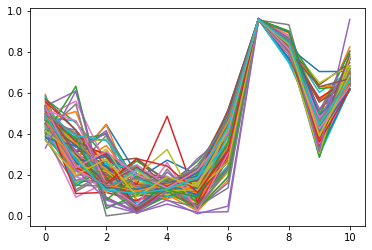

6


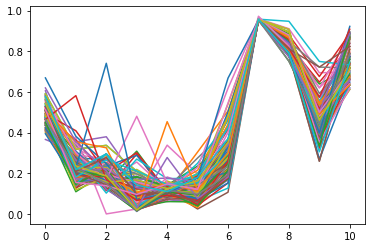

7


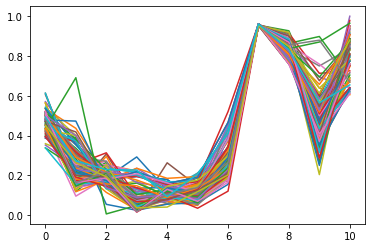

8


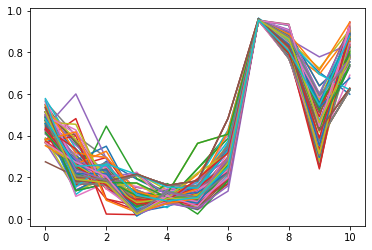

9


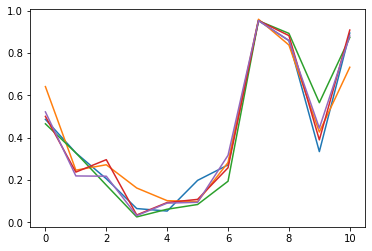

적어도 7번은 무의미한 데이터


In [3]:
data_total = {}
for d in data:
    if d[-1] not in data_total:
        data_total[d[-1]] = []
    data_total[d[-1]].append(d[:11])

from matplotlib import pyplot as plt
from random import sample

for i in range(4, 10):
    for d in sample(data_total[float(i)], min(100, len(data_total[float(i)]))):
        plt.plot(d)
    print(i)
    plt.show()
print("적어도 7번은 무의미한 데이터")

# 문제점 2
위는 각 등급별로 임의의 100개 이하의 데이터를 뽑아 시각화 한것이다.

일단 적어도 7번 (1부터 시작하면 8번 데이터) 데이터가 평가에 큰 영향을 끼치지는 않을것이란 추측을 얻어내었다.

하지만 각 등급간 데이터 특성이 전무해보인다. 위 그래프가 각 값의 최대값으로 나눠주는 형태로 0.0 ~ 1.0 사이의 값으로 정규화 한 후라는것을 고려해보면 몇몇 극단적인 값을 가지는 데이터가 숨겨져 있을것이란것을 추측할 수 있다.



4


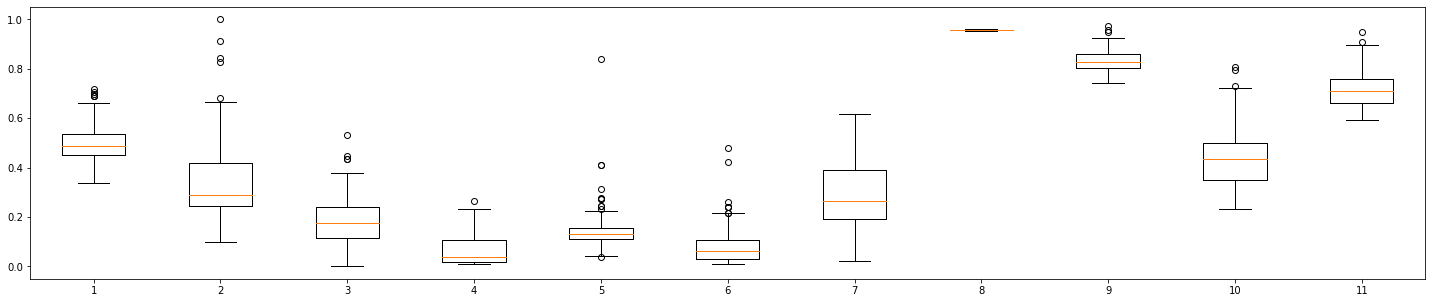

5


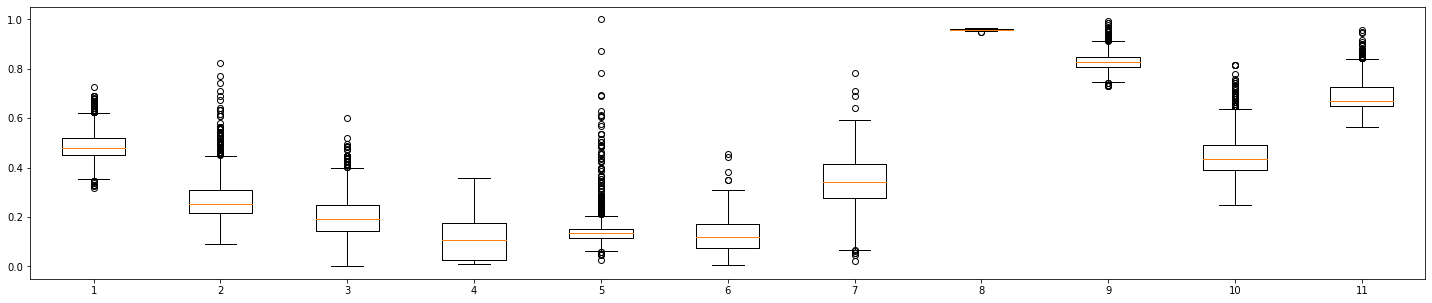

6


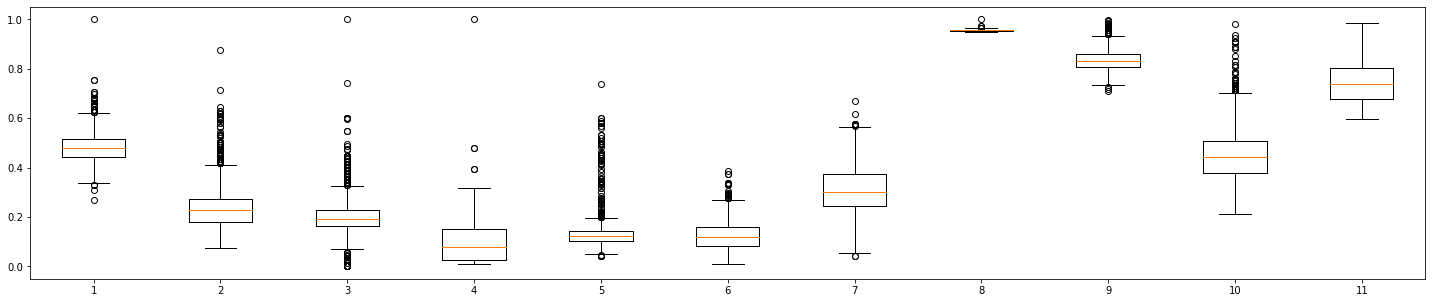

7


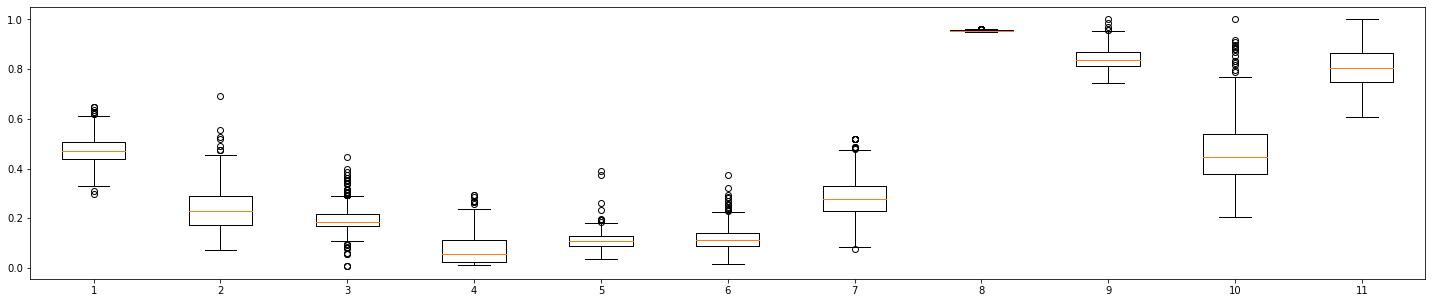

8


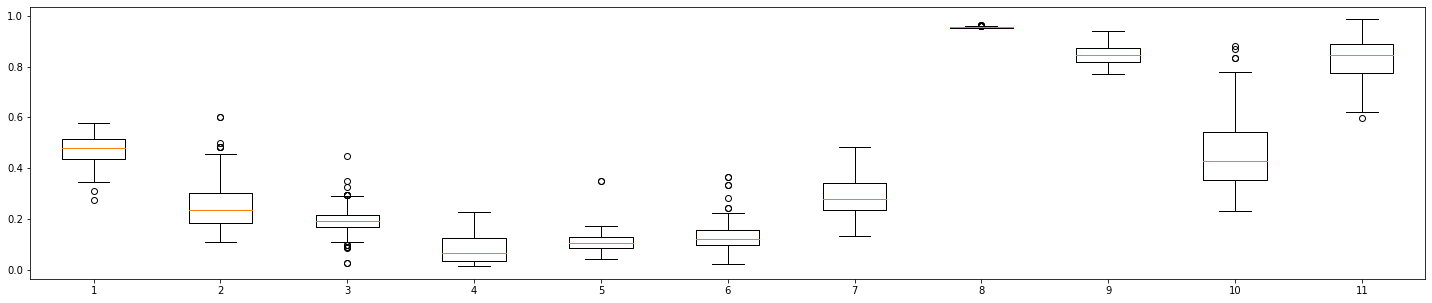

9


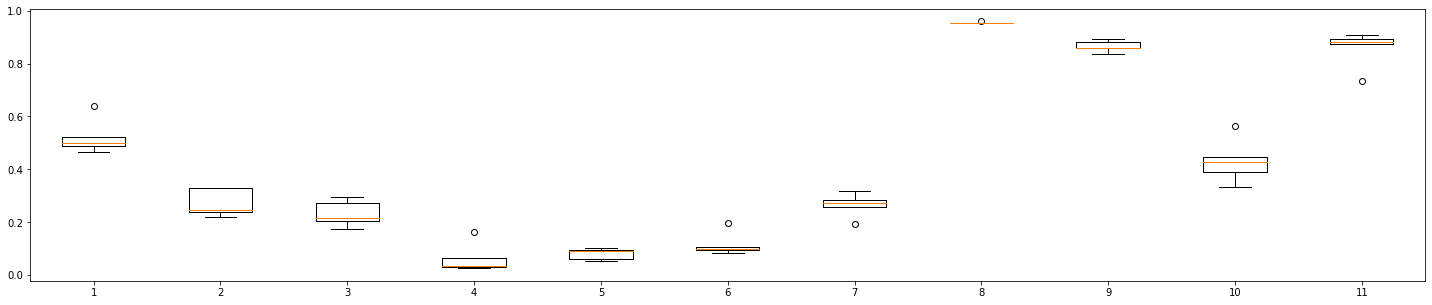

In [4]:
for index in range(4, 10):
    data = data_total[float(index)]
    plt.figure(figsize=(25, 5)) 
    tmp = [[] for _ in range(11)]
    for i in range(11):        
        for d in data:
            tmp[i].append(d[i])
    plt.boxplot(tmp, showfliers=True)
    print(index)
    plt.show()

# 문제점 3

데이터의 뚜렷한 패턴이 보이지 않고 편차가 너무 크며, 6.0 등급 와인 데이터를 제외하고는 그 수가 너무 적어 발견한 와인이 이를 대표하는 값인지 알아내기가 힘들다.

In [5]:
data_train = {}
data_valid = {}
for key in data_total:
    data_train[key] = []
    data_valid[key] = []
    length = len(data_total[key])
    pick = sample([i for i in range(length)], int(length/2)) # 절반씩 샘플링
    for i, d in enumerate(data_total[key]):
        if i in pick:
            data_train[key].append(d)
        else:
            data_valid[key].append(d)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2060


In [7]:
model = nn.Sequential(
            nn.Linear(11, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
            nn.Sigmoid())
model(torch.tensor(data[0][:11]))
model.cuda()

Sequential(
  (0): Linear(in_features=11, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=10, bias=True)
  (7): Sigmoid()
)

In [8]:
def load_data(data, sample_count = 3):
    x = []
    y = []
    for key in data:
        tmp = [0 for _ in range(10)]
        tmp[int(key)] = 1     
        if len(data[key]) > sample_count:   
            x.extend(sample(data[key], sample_count))
            y.extend([int(key) for _ in range(sample_count)])
        else:
            for i in range(sample_count):
                x.append(data[key][i % len(data[key])])
                y.append(int(key))
    x = torch.tensor(x)
    y = torch.tensor(y)
    return x, y
def validate(model, data):
    x = []
    y = []
    for key in data:
        x.extend(data[key])
        y.extend([int(key) for _ in range(len(data[key]))])
    x = torch.tensor(x)
    y_pred = model(x)
    good = 0
    bad = 0
    for i, _ in enumerate(y):
        if y[i] == torch.argmax(y_pred[i]):
            good += 1
        else:
            bad += 1
    return good / (good + bad), good, bad
    

In [10]:
from datetime import datetime
from IPython.display import clear_output
optimizer = optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
loss_fn = nn.CrossEntropyLoss()
start = datetime.now()
 
sample_count = 1000
for i in range(10000):
    for i in range(max(int(2198/sample_count), 1)):
        x_train, y_train = load_data(data_train, sample_count)     
        loss_train = 0.0

        x_train = x_train.to(device)
        y_train = y_train.to(device)

        y_pred = model(x_train)
        loss = loss_fn(y_pred, y_train)

        optimizer.zero_grad()        
        loss.backward()        
        optimizer.step()

        loss_train += loss.item()

    if (datetime.now() - start).seconds > 1:
        start = datetime.now()
        clear_output(wait=True)
        model.cpu()
        print('{}\t{}\t{}'.format(datetime.now(), validate(model, data_valid), loss.item()))
        model.cuda()

2020-11-25 23:57:09.391089	(0.4483884128926969, 1099, 1352)	1.0933597087860107


# 결과
학습은 실패하였다.

최고 정확도는 50% 수준이며, 모든 데이터를 가장 데이터가 많은 6등급 와인이라고 분류한다.

주어진 데이터는 와인의 등급을 매기는데 직접적으로 연관되어있지 않은 데이터라고 추정된다.